In [339]:
#coding utf8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, metrics
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn import svm


In [268]:
'''
Functions for loading in and combining data
'''
def load_df(file_name, sheet = 'Sheet 1'):
    '''
    Load a file into a data frame that is quarterly from the Eurostat website
    '''
    df = pd.read_excel(file_name, sheet_name=sheet)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.replace(':', np.nan, inplace=True)
    df.index = df.iloc[:, 0]
    df.drop(df.columns[[0]], axis=1, inplace=True)
    for i in df.columns[:]:
        df[i] = df[i].apply(pd.to_numeric, errors="coerce")
    df.interpolate(method='linear', inplace=True, axis = 1)
    df.sort_index(inplace=True)
    df = df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})
    return df

def create_per_employeer(GDP_df, HW_df, employees_df):
    ''' 
    Inputs: GDP, hours worked, and employees dataframes
    Output: dataframe with per-employee GDP and per hour worked GDP
    '''
    cols =(list(set(GDP_df.columns) and set(employees_df.columns) and set(HW_df.columns)))
    cols.sort()
    idx = cols.pop()
    per_employee_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    per_HW_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    for i in cols:
        per_employee_df[i] = GDP_df[i]/employees_df[i]
        per_HW_df[i] = per_employee_df[i]/HW_df[i]
    return per_employee_df, per_HW_df

def country_code_to_name(df):
    '''
    Renames country codes to country names
    '''
    df = df.rename({'AUT': 'Austria', 'BEL': 'Belgium', 'DEU': 'Germany','EST': 'Estonia','FIN': 'Finland','ESP': 'Spain','FRA': 'France','GRC': 'Greece','IRL': 'Ireland','ITA': 'Italy','LTU': 'Lithuania','LUX': 'Luxembourg','LVA': 'Latvia','PRT': 'Portugal','NLD': 'Netherlands','SVK': 'Slovakia','SVN': 'Slovenia','ISL': 'Iceland','GBR': 'United Kingdom','CHE': 'Switzerland','CZE': 'Cezch Republic','DNK': 'Denmark','HUN': 'Hungary','NOR': 'Norway','POL': 'Poland','SWE': 'Sweden'})
    return df

def yearly_to_quarterly(df):
    '''
    Inputs: df
    Converts the data from yearly to quarterly
    Outputs: quarterly_df
    '''
    data = df.to_numpy(dtype=np.float64)
    data = np.repeat(data, 4, axis = 1)
    quarterly_df = pd.DataFrame(data)
    quarterly_df.index = df.index
    quarterly_df.columns = GDP_df.columns[(int(df.columns[0]) - 1975)*4:(int(df.columns[-1]) - 2021)*4]
    return quarterly_df

def match_df(dfs):
    ''' 
    Input : dataframes
    This function matches dataframes by their index and column 
    Output: matched dataframes
    '''
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.intersection(set(i.index))
        cols = cols.intersection(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
    return dfs



In [176]:
'''
Functions for time series prediction
'''
def process_data(X, y, split_point, time_step, data_memory):
    '''
    Inputs: X, y, split_point, time_step, data_memory
    Splits data into training and testing data
    Outputs: X_train, X_test, y_train, y_test
    '''
    X_norm, X_attrs, y_norm, y_attrs = normalise(X, y)
    split_point = int(X_norm.shape[0] *split_point)
    y_norm = np.roll(y_norm, -time_step)
    nrows = X_norm.shape[0]
    samples = X_norm.shape[1]
    X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
    x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)
    return x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs

def normalise(X, y):
    '''
    Inputs: X, y
    Normalises the data by subtracting the mean and dividing by the standard deviation
    Outputs : X_norm, y_norm, X_attrs, y_attrs
    '''
    X_attrs = np.zeros((X.shape[-1], 2))
    y_attrs = np.zeros((y.shape[-1], 2))
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    for i in range(y.shape[-1]):
        y_attrs[i, :] = [np.mean(y[:, i]), np.var(y[:, i])]
        y[:, i] = (y[:, i] - np.mean(y[:, i]))/np.var(y[:, i])**0.5  
    return X, X_attrs, y, y_attrs

def train_test_split(X, y, split_point):
    '''
    Splits the data into training and testing data
    '''
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test
        
def create_model(layers, input_shape, print_summary):
    '''
    Creates a model with the specified layers
    '''
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam', metrics = [tf.keras.metrics.MeanSquaredError()])
    if print_summary:
        model.summary()
    return model

def run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point):
    '''
    Inputs: X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point
    Runs the model on the data
    Outputs: model, history
    '''
    x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs = process_data(X, y, split_point, time_step, data_memory)
    input_shape = (x_train.shape[0], data_memory, samples)
    model = create_model(model_layer, input_shape, print_summary)
    history = model.fit(x_train, y_train, validation_split = 0.1, epochs= epochs , batch_size=batch_size)
    y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
    y_pred_norm = np.roll(y_pred_norm, 1, axis = 1)
    y_pred = np.roll(y_pred_norm *y_attrs[:, 1]**0.5 + y_attrs[:, 0] , 0)
    mse = metrics.MeanSquaredError()
    mse.update_state(y_norm, y_pred_norm)
    test_loss = mse.result().numpy()
    print(test_loss)
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    model_performance = [time_step, data_memory, samples, epochs, batch_size, train_loss, val_loss, test_loss]
    df_model = pd.DataFrame(model_performance).transpose()
    df_model.to_csv('model_performance.csv', mode = 'a', header= False)
    return y, y_pred, history


In [329]:
'''
Regression stuff
'''

def run_regr(X, y, t, regr, colours):
    regr.fit(X, y)
    nrows = X.shape[0]
    y_reg, abs_loss, per_loss = np.zeros(nrows), np.zeros(nrows), np.zeros(nrows)  
    for i in range(nrows):
        y_reg[i] = regr.predict(np.array([X[i, :]]))
    plt.plot(t, y, colours[0], t, y_reg, colours[1])
    for i in range(nrows):
        abs_loss[i] = np.abs(y[i] - y_reg[i])
        if y[i] > 0:
            per_loss[i] = abs_loss[i] / y[i]
    total_loss, loss = np.sum(abs_loss)/ nrows, np.sum(per_loss)/ nrows
    print('Total loss: ', total_loss, '\n Loss: ', loss)
    return total_loss, loss

In [270]:
'''
Loads in gross domestic product, hours worked and employees data
Returns GDP per employee and GDP per hour worked
'''
GDP_df =  load_df('./data/GDP_per_quarter_2.xlsx') * 1e6
HW_df = load_df('./data/hours_worked.xlsx')
employees_df = load_df('./data/Employees.xlsx') * 1e3
per_employee_df, per_HW_df = create_per_employeer(GDP_df, HW_df, employees_df)

#per_HW_df.iloc[4, :].T.plot(legend = False)

In [281]:
'''
Depression data
'''
dep_df = pd.read_csv('data/depression_by_age.csv') 
dep_df = dep_df.drop(['Prevalence - Depressive disorders - Sex: Both - Age: 10 to 14 (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: All Ages (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: 70+ years (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent)', 'Prevalence - Depressive disorders - Sex: Both - Age: 15-49 years (Percent)'],axis=1)
a = ['Belgium','Bulgaria','Denmark','Germany','Estonia','Ireland','Greece','Spain','France','Croatia','Italy','Cyprus','Latvia','Lithuania','Luxemburg','Hungary','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia','Slovakia','Finland','Sweden','Iceland','Norway','Switzerland','United Kingdom','Montenegro','North Macedonia','Serbia','Turkey']
dep_df = dep_df[dep_df['Entity'].isin(a)]
dep_df['Age:15-69_depression_average']=dep_df.iloc[:,3:7].mean(axis=1,skipna=True)
dep_df = dep_df.pivot_table('Age:15-69_depression_average', ['Entity', 'Code'], 'Year')
dep_df = dep_df.reset_index('Code')
del dep_df['Code']
dep_quarterly_df = yearly_to_quarterly(dep_df)

'''
Education data
'''
education_dfs = [None] * 4
for i in range(4):
    education_dfs[i] = load_df('./data/Education.xlsx', 'Sheet ' + str(4*i + 1))
    education_dfs[i] = yearly_to_quarterly(education_dfs[i])
    education_dfs[i] = education_dfs[i].rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})

'''
Inflation data
'''
inf_df = pd.read_csv('data/Quarterly_infilation.csv')
inf_df =inf_df.drop(['SUBJECT', 'MEASURE','FREQUENCY','Flag Codes'], axis=1)
inf_df = inf_df.pivot_table('Value', ['LOCATION', 'INDICATOR'], 'TIME')
inf_df = country_code_to_name(inf_df)
inf_df = inf_df.reset_index('INDICATOR')
del inf_df['INDICATOR']
inf_df = inf_df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})

'''
Unemployment data
'''
unem_df = pd.read_csv('./data/unem.csv')
unem_df.fillna(0)
unem_df = unem_df[['LOCATION', 'TIME', 'Value']]
unem_df = unem_df.pivot_table('Value',  ['LOCATION'],'TIME')
unem_df = country_code_to_name(unem_df)

In [319]:
'''
Combine all dataframes and create a numpy array of the data
Data = [Country, Time, Feature]
'''
dfs = [per_employee_df, per_HW_df] + education_dfs + [inf_df, unem_df, dep_quarterly_df]
matched_dfs = match_df(dfs)
data = np.zeros((len(matched_dfs[0].index), len(matched_dfs[0].columns),  len(matched_dfs)))
for i in range(len(matched_dfs)):
    data[:, :, i] = matched_dfs[i].to_numpy(dtype=np.float64)
data.shape

(15, 48, 9)

Total loss:  268.3040947575161 
 Loss:  0.01154374135656412


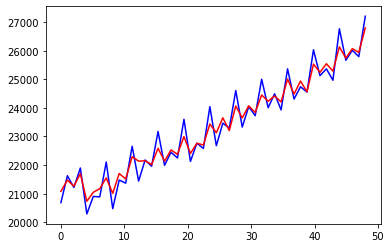

In [348]:
X = data[0, :, 2:]
y = data[0, :, 0]
t = np.linspace(0, y.shape[0], y.shape[0])
total_loss, loss = run_regr(X, y, t, RandomForestRegressor(), ['b', 'r'])

In [349]:
from sklearn.cluster import KMeans


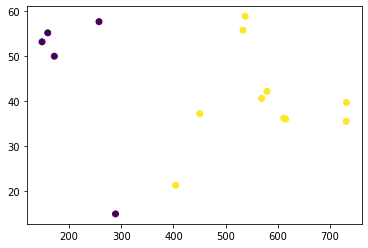

In [384]:
'''
Clustering of features using K-means
'''
X = data[:, 0, :]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
plt.scatter(X[:, 1], X[:, 4], c= kmeans.labels_)

In [314]:
time_step, data_memory, epochs, batch_size, split_point = 5, 5, 10, 1, 0.9

load_model_bool, load_model, save_model, save_fig = False, 'EU_model', 'EU_model', 'EU'
model_layer = [layers.Dense(8, activation= 'linear'),
                layers.LSTM(4,activation= 'sigmoid', dropout = 0.1, recurrent_dropout = 0.1, return_sequences=False),
                layers.Dense(8, activation='linear'),
                layers.Dense(2)]
print_summary = True
y, y_pred, history = run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (43, 5, 8)                64        
                                                                 
 lstm_5 (LSTM)               (43, 4)                   208       
                                                                 
 dense_16 (Dense)            (43, 8)                   40        
                                                                 
 dense_17 (Dense)            (43, 2)                   18        
                                                                 
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
38/38 [==============================] - 3s 12ms/step - loss: 0.1851 - mean_squared_error: 0.1851 - val_loss: 0.9159 - val_mean_squared_error: 0.9159
Epoch 2/10
38/38 [=========

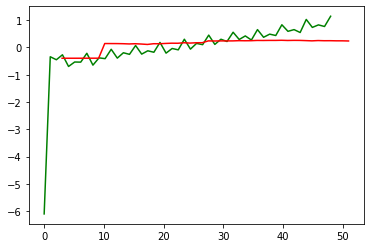

In [315]:
t = np.linspace(0, y_pred.shape[0], y_pred.shape[0])
plt.plot(t, y[:, 0], 'g', t + time_step - 2, y_pred[:, 0], 'r')
train_loss = history.history['loss']
val_loss = history.history['val_loss']